# Mooomentums
Mooom is a strategy that heavily relies on momentum. It enriches dataframe with simple momentum and industrial momentum factors. Returns will be substracted by a cross-sectional median.

In [1]:
from functools import reduce
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import warnings
warnings.filterwarnings('ignore')
import ta 
from ta.volatility import BollingerBands

In [2]:
df = pd.read_parquet("compustat_raw_alpha.1.parquet")

FileNotFoundError: [Errno 2] No such file or directory: 'compustat_raw_alpha.1.parquet'

In [24]:
def conf(clf, X_test, y_test):
    f, ax = plt.subplots(figsize=(4.8, 4.8))
    y_test_pred = clf.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    conf_ax = sns.heatmap(
        conf_mat, ax=ax, annot=True, fmt="", cmap=plt.cm.Blues, cbar=False
    )
    conf_ax.set_xlabel("Predicted")
    conf_ax.set_ylabel("True")

In [25]:
def extreme(df):
    """Retain the 20% values that are the smallest and the 20% that are the largest."""
    top = df.y.quantile(0.8)
    low = df.y.quantile(0.2)
    return df[(df.y < low) | (df.y > top)]

In [26]:
def mooom(df):
    """
    Mooom is a strategy that heavily relies on momentum.
    It enriches dataframe with simple momentum and industrial momentum factors. 
    Returns will be substracted by a cross-sectional median.
    """
    df_mom = df[["classification",
                 "mcap",
                 "act",
                 "ceq",
                 "cogs",
                 "lct",
                 "nicon",
                 "revt",
                 "xrd",
                 "prccd",
                 "close",
                'cshoc',
                'dvc','dlc','dltt','pstk','mib','chee','revt','ebitda']]
    times = [3, 4, 5, 10, 20, 40]
    df_mom["log_return"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x.shift(-3)) - np.log(x))
    df_mom['market_eve'] =(df.mcap + (df.dlc + df.dltt + df.pstk + df.mib - df.chee) * 10 ** 6)
    df_mom['market_eveda']=(df_mom.mcap + (df_mom.dlc + df_mom.dltt + df_mom.pstk + df_mom.mib - df_mom.chee) * 10 ** 6)/ (df_mom.ebitda * 10 ** 6)
#    df_mom['market_dyr'] = (df_mom.dvc * 10 ** 6 / df_mom.cshoc / df_mom.prccd)
#    df_mom["profitability_npm"] = (df_mom.nicon / df_mom.revt)
    df_mom["profitability_roe"]=df_mom.nicon / df_mom.ceq
    df_mom["intangible_rdm"] = df_mom.xrd / df_mom.mcap
    df_mom["liquid_cur"] = df_mom.act / df_mom.lct
    df_mom["market_pe"] = df_mom.mcap / (df_mom.nicon * 10 ** 6)
    df_mom["market_mb"] = df_mom.mcap / (df_mom.ceq * 10 ** 6)
    df_mom["52wk_high"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x) - np.log(x.rolling(12, min_periods=1).max()))
    df_mom["mom_12m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x.shift(2))-np.log(x.shift(13)))
    df_mom["mom_6m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x).shift(2) - np.log(x.shift(7)))
    df_mom["mom_1m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x) - np.log(x.shift(1)))
#    df_mom["Bollinger_Band_High"] = df_mom.groupby("gvkey").apply(indicator_bb.bollinger_hband_indicator())
    df_mom["ind_mom_12m"] = df_mom.groupby(["date", "classification"]).mom_12m.transform("mean")
    df_mom["ind_mom_6m"] = df_mom.groupby(["date", "classification"]).mom_6m.transform("mean")
    df_mom["ind_mom_1m"] = df_mom.groupby(["date", "classification"]).mom_1m.transform("mean")
    df_mom["y"] = df_mom.groupby("date").log_return.transform(lambda x: (x - x.median()).clip(-1,1))
    return df_mom.loc[(df.prccd > 5) & (df.mcap > 500000000) & (df.nicon >0), ["mcap",
                                     "profitability_roe",
                                     "intangible_rdm",
                                     "liquid_cur",
                                     "market_mb",
                                     "market_pe",
                                     "52wk_high",
                                     "mom_12m",
                                     "mom_6m",
                                     "mom_1m",
                                     "ind_mom_12m",
                                     "ind_mom_6m",
                                     "ind_mom_1m",
                                     'market_eveda',
                                     'market_eve',
                                     "y"]].dropna()

In [27]:
df_mom = mooom(df)

In [28]:
#times = [3, 4,12]
#for time in times:
#        df_mom[f"RET {time}"] = df_mom['close'].groupby("gvkey").transform(lambda x: x.pct_change(time - 1))
#        df_mom[f"STD {time}"] = df_mom['log_return'].groupby("gvkey").transform(lambda x: x.rolling(time).std())
##        df_mom[f"SH {time}"] = df_mom['log_return'].groupby("gvkey").transform(lambda x: x.rolling(time).mean() / x.rolling(time).std())
#        df_mom[f"QT {time}"] = df_mom['close'].groupby("gvkey").transform(lambda x: x.rolling(time).quantile(0.75) / x)

## Regression

## Binary Classification

## Multi Classification

In [29]:
def threshold(y):
    thres = 0.2
    y_0 = np.where(y < -thres, -1, y)
    y_1 = np.where((y <= thres) & (y >= -thres), 0, y_0)
    y_2 = np.where(y > thres, 1, y_1)
    return y_2

## Portfolio Return

In [30]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False).groupby("date").apply(extreme)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train= threshold(df_train.y)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = threshold(df_test.y)
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred= xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, 
                            y_pred, target_names=["sell", "hold", "buy"]))

Accuracy on training set: 0.60936582501468
Accuracy on test set: 0.2284429381476895
              precision    recall  f1-score   support

        sell       0.17      0.35      0.23      2042
        hold       0.77      0.05      0.09     10078
         buy       0.22      0.73      0.34      3223

    accuracy                           0.23     15343
   macro avg       0.39      0.37      0.22     15343
weighted avg       0.57      0.23      0.16     15343



In [31]:
df_train.columns[6]

'52wk_high'

<AxesSubplot:>

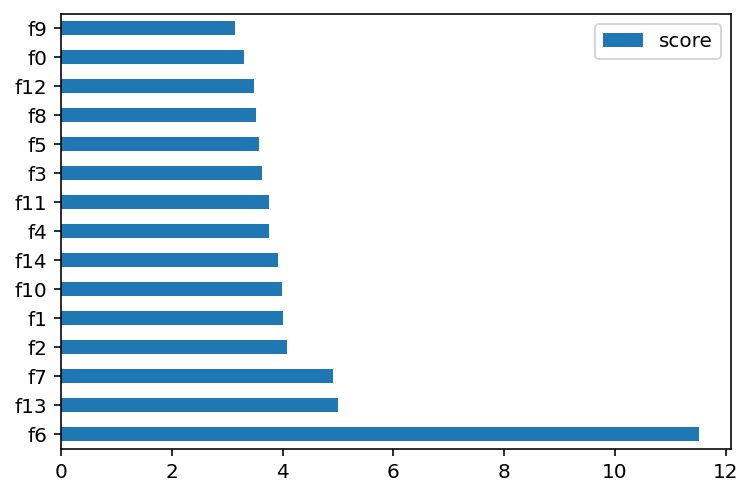

In [32]:
feature_important = xgb_fit.get_booster().get_score(importance_type="gain")
keys = list(feature_important.keys())
values = list(feature_important.values())
%config InlineBackend.figure_format = 'retina'
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

In [33]:
def frame_to_signals(frame, estimator):
    X = frame.drop(columns="y").to_numpy()
    short_array = -1 * estimator.predict_proba(X)[:, 0]
    long_array = estimator.predict_proba(X)[:, -1]
    short_signal = pd.Series(short_array, frame.index)
    long_signal = pd.Series(long_array, frame.index)
    return short_signal, long_signal

In [34]:
def noise_to_belief(signal, n):
    return signal.groupby("date", group_keys=False).apply(lambda x: x.sort_values(ascending=False, key=abs).head(n))

In [35]:
def monthly_to_daily(signal, months, weight):
    daily_signals = []
    for index, value in signal.iteritems():
        gvkey = index[0]
        predict_date = pd.to_datetime(index[1])
        start = predict_date + DateOffset(days=1)
        end = predict_date + DateOffset(months=months)
        date_range = pd.date_range(start, end, freq="D", name="date")
        daily_idx = pd.MultiIndex.from_tuples([(gvkey, date) for date in date_range], names=["gvkey", "date"])
        if weight == "equal":
            daily_signal = pd.Series(np.sign(value), daily_idx)
        elif weight == "value":
            daily_signal = pd.Series(value, daily_idx)
        daily_signals.append(daily_signal)
    return pd.concat(daily_signals)

In [36]:
def signals_to_positions(short_signal, long_signal, n=10, months=3, weight="equal"):
    short_belief = noise_to_belief(short_signal, n)
    long_belief = noise_to_belief(long_signal, n)
    short_daily = monthly_to_daily(short_belief, months, weight)
    long_daily = monthly_to_daily(long_belief, months, weight)
    short_position = short_daily.groupby(["gvkey", "date"]).agg("sum")
    long_position = long_daily.groupby(["gvkey", "date"]).agg("sum")
    neutral_position = pd.concat([short_position, long_position]).groupby(["gvkey", "date"]).agg("sum")
    return short_position, long_position, neutral_position

In [37]:
def position_to_margin(data, position, tx=-0.001, method="log"):
    merged = pd.merge(position.rename("position"), data.close, how="left", left_index=True, right_index=True)
    merged["close"] = merged.close.groupby("gvkey").fillna(method="ffill")
    merged["tx"] = np.where(position.shift(1) != position, tx, 0)
    if method == "log":
        merged["margin"] = merged.close.groupby("gvkey").transform(lambda x: np.log(x / x.shift(1))).fillna(0)
        margin = merged.position * merged.margin + merged.tx
        margin = margin.droplevel("gvkey").resample("D").mean().cumsum()
    elif method == "percent":
        merged["margin"] = merged.close.groupby("gvkey").transform(lambda x: x.pct_change(1)).fillna(0)
        margin = merged.position * merged.margin + merged.tx
        margin = (margin.droplevel("gvkey").resample("D").mean()+1).cumsum()
    return margin

In [38]:
def sharpe_ratio(data, position):
    merged = pd.merge(position.rename("position"), data.close, how="left", left_index=True, right_index=True)
    merged["close"] = merged.close.groupby("gvkey").fillna(method="ffill")
    merged["tx"] = np.where(position.shift(1) != position, -0.001, 0)
    merged["margin"] = merged.close.groupby("gvkey").transform(lambda x: x.pct_change(1)).fillna(0)
    margin = merged.position * merged.margin + merged.tx
    margin = margin + merged.tx * abs(margin)
    margin = margin.droplevel("gvkey").resample("D").mean()
    return margin.mean() / margin.std() * np.sqrt(252)

In [39]:
data = pd.read_parquet("daily_price_backtest.parquet")
data = data[~data.index.get_level_values("gvkey").isin(['104843', '249103'])]
short_signal, long_signal = frame_to_signals(df_test, xgb_clf)
short_position, long_position, neutral_position = signals_to_positions(short_signal, long_signal, n=50, months=3, weight="equal")

Sharpe ratio: 1.315677644659987


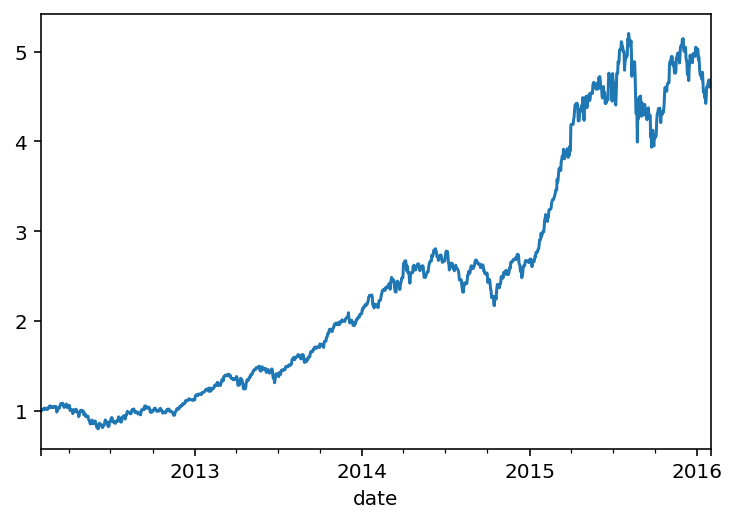

In [40]:
margin = position_to_margin(data, long_position, method="percent")
margin.plot()
sharpe = sharpe_ratio(data, long_position)
print(f"Sharpe ratio: {sharpe}")

Sharpe ratio: -1.6153475979226923


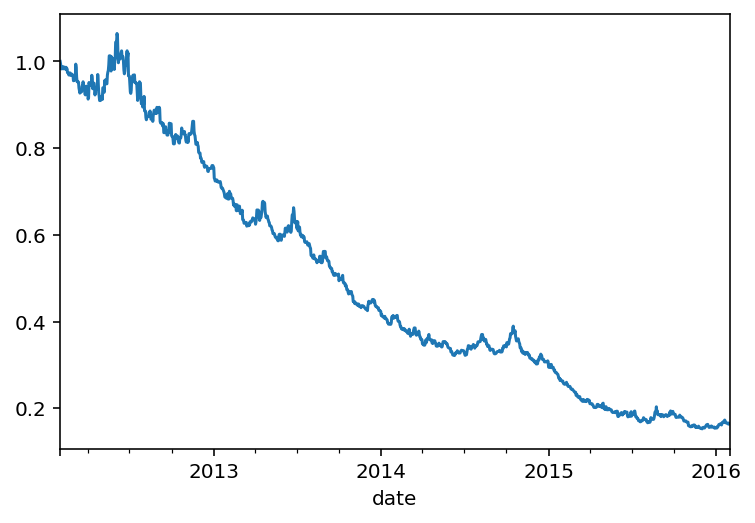

In [41]:
margin = position_to_margin(data, short_position, method="percent")
margin.plot()
sharpe = sharpe_ratio(data, short_position)
print(f"Sharpe ratio: {sharpe}")

Sharpe ratio: -0.2704337798664499


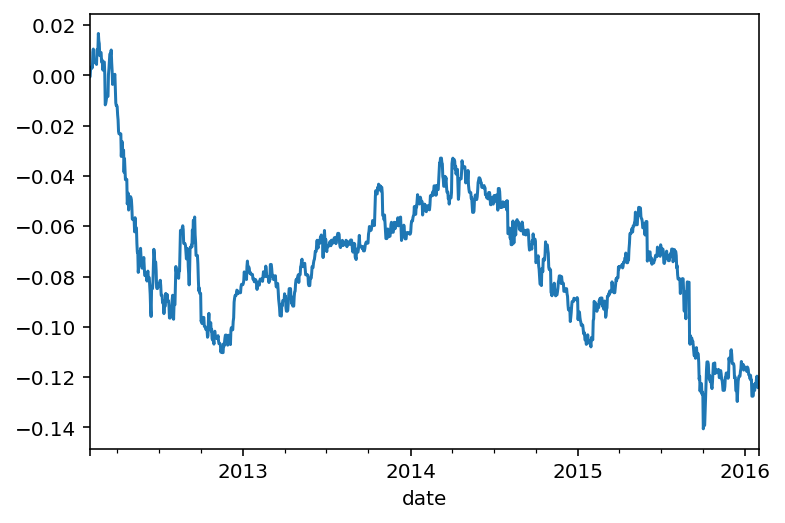

In [43]:
margin = position_to_margin(data, neutral_position, method="log")
margin.plot()
sharpe = sharpe_ratio(data, neutral_position)
print(f"Sharpe ratio: {sharpe}")